# <div style="text-align: center">LTI Reconstruction Demo </div>
<div style="text-align: center">AWESEM Signal Processing </div>
<br>
<div style="text-align: center">Erick Blankenberg, 8/5/2019 </div>

---
## <div style="text-align: center">Introduction </div>
In this module we apply the system model that we observed from the phase-magnitude demo to an arbitrary driving waveform.
<br>
<br>
Below we import both model parameters from the aftermentioned demo and the arbitrary waveform data (a 256 sample array) that would be loaded in a microcontroller. 
<br>
<br>
The microcontroller plays values linearily interpolated from this 256 sample array at a rate of 44,117 Hz. The imported system model is assumed to be derived TODO.

Frequency Cutoff: -43.1748 (dB) 6235.5073 (Hz)
1 loop, best of 3: 6.39 s per loop
1 loop, best of 3: 3.68 s per loop
100 loops, best of 3: 5.14 ms per loop


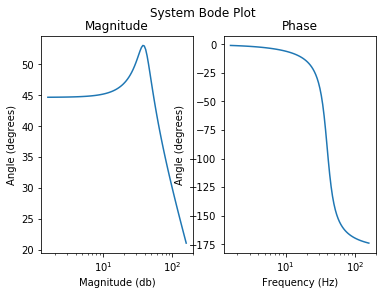

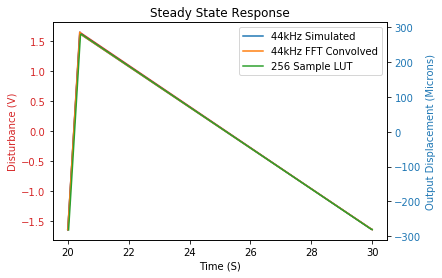

In [73]:
import numpy
import pandas
from   scipy import signal
from   scipy import fftpack
import os
import matplotlib.pyplot as pyplot
from math import ceil
import timeit

%matplotlib inline

systemLUTLen      = 256   # Number of samples for LUT of response in practical system, values linearily interpolated between these (TODO get derivation to show why 1x is ok, 2x+ is better, generally prove sane ranges)
systemAudioRate   = 44117.64706 # (Hz) How fast the MCU will create samples 
waveformFrequency = 0.1   # (Hz) how fast we want to play the periodic waveform
transientTime     = 1.0   # (S) (TODO replace with value derived from system model and impulse response) how long until startup transients can be ignored
extendPeriods     = 2.0   # How many periods after the transient time to use
cutoffDB          = -40.0   # (dB) For suggesting bounds on lookup table size, magnitude that corresponds to highest frequency after which system is assumed to completely stop excitation signal
maxTestFreq       = 10000.0 # (Hz) Highest frequency to check for cutoff

# Imports system
systemParameterFilePath = os.path.join(os.getcwd(), 'SystemParams/TransFunc_OIS.txt')
with open(systemParameterFilePath,'r') as inf:
    systemParameters = eval(inf.read())
SystemModel      = signal.ZerosPolesGain(systemParameters['Zeros'], systemParameters['Poles'], systemParameters['Gain'])
# > Identifies frequency cutoff of system, assumed that magnitude monotonically decreases after this point
testFrequenciesHz        = numpy.logspace(start = 0.0, stop = numpy.log10(maxTestFreq), base = 10.0, num = numpy.log10(maxTestFreq) * 10)
limitFrequencies, limitMagDb, _ = SystemModel.bode(testFrequenciesHz * 2 * numpy.pi)
lowerVals = numpy.nonzero(limitMagDb < cutoffDB)
if(lowerVals[0].shape[0] > 0):
    firstIndex = lowerVals[0][0]
    print("Frequency Cutoff: %0.4f (dB) %0.4f (Hz)" % (limitMagDb[firstIndex], limitFrequencies[firstIndex] / (2.0* numpy.pi)))
else:
    print("Lower limit not found in frequency bounds, lowest magnitude: %0.4f (Db), %0.4f (Hz)" % (limitMagDb[-1], limitFrequencies[-1] / (2.0* numpy.pi)))


# Imports waveform
wavetableFilePath       = os.path.join(os.getcwd(), 'WaveTables/Custom.csv')
wavetableRaw = numpy.genfromtxt(wavetableFilePath, delimiter = ',')
# > You can uncomment this to make a skewed triangular waveform
riseLength = 10
wavetableRaw = numpy.round(numpy.concatenate((numpy.linspace(-32767, 32767, riseLength, endpoint = False), numpy.linspace(32767, -32767, 256 - riseLength, endpoint = False)))).astype(numpy.int16)
#numpy.savetxt("Waveform_CustomTriangle.csv", vals)

# Imports the wave table data
waveformPeriodLength    = 1.0 / waveformFrequency
wavetablePadded         = (numpy.append(wavetableRaw, wavetableRaw[0]) / 32767.0) * (3.3 / 2.0) # Convertes 16 bit signed integer to vpp, also pads with first sample at end to emulate wraparound, note that MCU does the same thing
wavetableTimes          = numpy.append(numpy.arange(start = 0, stop = waveformPeriodLength, step = waveformPeriodLength / float(wavetableRaw.shape[0])), waveformPeriodLength + waveformPeriodLength / float(wavetableRaw.shape[0]))
oneShotTimes44k         = numpy.arange(start = 0, stop = waveformPeriodLength, step = 1.0/systemAudioRate)
oneShotVals44k          = numpy.interp(oneShotTimes44k, wavetableTimes, wavetablePadded)
periodLength44k         = oneShotVals44k.shape[0]
numPeriods              = int(ceil(transientTime * waveformFrequency) + extendPeriods)
extendedShotVals44k     = numpy.tile(oneShotVals44k, numPeriods) # Clears transient time + last period is clean
extendedShotTimes44k    = numpy.linspace(0, numPeriods * waveformPeriodLength, extendedShotVals44k.shape[0])
oneShotTimesLUT         = numpy.linspace(start = 0, stop = waveformPeriodLength, num = systemLUTLen)
oneShotValsLUT          = numpy.interp(oneShotTimesLUT, wavetableTimes, wavetablePadded)
extendedOneShotValsLUT  = numpy.tile(oneShotValsLUT, numPeriods) # Clears transient time + last period is clean
extendedOneShotTimesLUT = numpy.linspace(0, numPeriods * waveformPeriodLength, extendedOneShotValsLUT.shape[0])

# Plots bode plot of system
w, mag, phase = SystemModel.bode()
fig, axis = pyplot.subplots(1, 2)
fig.suptitle('System Bode Plot')
axis[0].set_title('Magnitude')
axis[0].semilogx(w / (2.0 * numpy.pi), mag)
axis[0].set_ylabel('Angle (degrees)')
axis[0].set_xlabel('Magnitude (db)')
axis[1].set_title('Phase')
axis[1].semilogx(w / (2.0 * numpy.pi), phase)
axis[1].set_ylabel('Angle (degrees)')
axis[1].set_xlabel('Frequency (Hz)')

# Simulates response 
# Lsim does not use convolution to determine impulse response
(newTime, newVals, xOut) = signal.lsim(SystemModel, extendedShotVals44k, extendedShotTimes44k, interp = "False")
%timeit signal.lsim(SystemModel, extendedShotVals44k, extendedShotTimes44k, interp = "False") # About 180 ms on my machine 
# Uses DFT with impulse response of the system model
impulseResp = fftpack.ifft(fftpack.fft(SystemModel.impulse(T = extendedShotTimes44k)[1]) * fftpack.fft(extendedShotVals44k)) / systemAudioRate
%timeit fftpack.ifft(fftpack.fft(SystemModel.impulse(T = extendedShotTimes44k)[1]) * fftpack.fft(extendedShotVals44k)) / systemAudioRate # About 53 ms on my machine (dft circular conv. is faster)
# TODO Impulse Matched Difference Equation
# LUT derived from LSIM
(newTimesLUT, newValsLUT, xOutLUT) = signal.lsim(SystemModel, extendedOneShotValsLUT, extendedOneShotTimesLUT, interp = "True")
%timeit signal.lsim(SystemModel, extendedOneShotValsLUT, extendedOneShotTimesLUT, interp = "True")


# Plots wave table for two periods at desired frequency
pyplot.figure()
colorDisturbance = 'tab:red'
colorResponse = 'tab:blue'
pyplot.plot(extendedShotTimes44k[-(periodLength44k):], extendedShotVals44k[-(periodLength44k):], color = colorDisturbance, label = 'Disturbance')
pyplot.ylabel('Disturbance (V)', color = colorDisturbance)
pyplot.tick_params(axis='y', labelcolor=colorDisturbance)
pyplot.xlabel('Time (S)')
secondPlot = pyplot.twinx()
secondPlot.plot(newTime[-(periodLength44k):], newVals[-(periodLength44k):], label = '44kHz Simulated')
secondPlot.plot(extendedShotTimes44k[-periodLength44k:], impulseResp[-periodLength44k:], label = '44kHz FFT Convolved')
secondPlot.plot(newTimesLUT[-systemLUTLen:], newValsLUT[-systemLUTLen:], label = '%s Sample LUT' % systemLUTLen)
secondPlot.set_ylabel('Output Displacement (Microns)', color = colorResponse)
secondPlot.tick_params(axis='y', labelcolor=colorResponse)
pyplot.legend()
pyplot.title('Steady State Response')
pyplot.legend()
pyplot.show()

There are a few ways to find the steady state response of the system to the periodic input. 
<br>
<br>
The brute force approach is to use the "l-sim" method given by scipy signal, which simulates the system in the time domain with the given input signal directly. In this case we set "interp = False" as in reality our simulated discrete waveform is reconstructed using a zero-order hold by the microcontroller at 44,117.64706 Hz (our simulated waveform has one sample per hold period). This method requires that we extend our input waveform so that the response to the final period is representative of steady state. We identify the steady state behavior by isolating the last period.
<br>
<br>
The other approach is to find the response of the system to this periodic input via circular convolution. As the impulse response of the system is substantially longer than the waveform period (for this system and for most frequencies of interest) we extend the waveform as above and also zero-pad the impulse response so that it is the same length as this vector (assuming that last valid sample of the impulse response is very small). We then find the DFT of both of these vectors, multiply, than take the inverse DFT. Any of the periods in the result should be a valid representation of the steady state behavior assuming that we captured the impulse response sufficiently.
<br>
<br>
See both reconstructions and timing data below. 

100.0


/Users/ANoSenseSolution/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/Users/ANoSenseSolution/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/Users/ANoSenseSolution/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


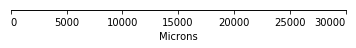

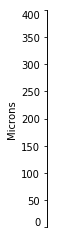

In [140]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import scipy.misc

def cropInvisAway(image):
    imageInverseMask = image[:, :, 3] # Areas where plotting occured have high alpha values
    imageHorizontalSums = numpy.sum(imageInverseMask, axis = 0)
    nonZeroHoriz = numpy.nonzero(imageHorizontalSums)[0]
    firstHoriz   = nonZeroHoriz[0]
    lastHoriz    = nonZeroHoriz[-1]
    imageVerticalSums = numpy.sum(imageInverseMask, axis = 1)
    nonZeroVert  = numpy.nonzero(imageVerticalSums)[0]
    firstVert    = nonZeroVert[0]
    lastVert     = nonZeroVert[-1]
    croppedImage = image[(firstVert - 1):(lastVert + 1), (firstHoriz - 1):(lastHoriz + 1), :]
    return croppedImage

# make an agg figure
scaleX = 30000
yMaxMicrons = 400

xRange = numpy.linspace(0, scaleX)
yRange = numpy.linspace(0, scaleY)

# Gets horizontal axis
# > Generates
fig, ax = plt.subplots()
ax.set_aspect(0.1)
ax.set_yticks([])
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.set_xlim(0, scaleX)
xTick_objects = ax.xaxis.get_major_ticks()
xTick_objects[0].label1.set_horizontalalignment('left')   # left align first tick 
xTick_objects[-1].label1.set_horizontalalignment('right') # right align last tick
plt.xlabel("Microns")
# > Gets canvas buffer
canvas = FigureCanvasAgg(fig)
canvas.draw()
s, (width, height) = canvas.print_to_buffer()
X = cropInvisAway(np.fromstring(s, np.uint8).reshape((height, width, 4)))

# Gets vertical axis 
# > Generates
fig, ax = plt.subplots()
ax.set_aspect(1000)
ax.set_xticks([])
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.set_ylim(0, yMaxMicrons)
yTick_objects = ax.yaxis.get_major_ticks()
yTick_objects[0].label1.set_verticalalignment('bottom')   # left align first tick
yTick_objects[-1].label1.set_verticalalignment('top') # right align last tick
plt.ylabel("Microns")
# > Gets canvas buffer
canvas = FigureCanvasAgg(fig);
canvas.draw();
s, (width, height) = canvas.print_to_buffer()
Y = cropInvisAway(numpy.frombuffer(s, numpy.uint8).reshape((height, width, 4)))

scipy.misc.imsave('outfile_x.png', X)
scipy.misc.imsave('outfile_y.png', Y)

print("%s"% 100.0)